Preliminary insights have been given in the Exploratory Data Analysis section below.

AUC tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. It is used as the evaluation metric as the classification problems actually outputs probability of a person experiencing financial distress for next two years, and we need a threshold can convert the probability outputs to classifications. The numbers will change depends on the threshold selected and hence the ROC curve plots of the false positive rate over the true positive rate for easy viewing of what happens when different threshold value is varied.

Recall will be another good evaluation metric because it punishes the false negative cases where the model predict a person will not experience financial distress for next two years and the banks grant a loan to the person, only to find that the person defaulted, resulting in high loss for the banks. 

I have selected Random Forest as my model for this question due to its high recall and high AUC.
But unfortunately, I did not get into top 100 in the private leaderboard.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMModel, LGBMClassifier

In [2]:
# Set working directory
os.chdir('C:\\Users\\koh.chinnam.andrew\\OneDrive\\Desktop\\Untitled Folder\\GiveMeSomeCredit')

In [3]:
# Loading training dataset
df_train = pd.read_csv('cs-training.csv', index_col=0)
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# Loading test dataset
df_test = pd.read_csv('cs-test.csv', index_col=0)
df_test.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [5]:
# Preparing test data for use later
# Dropping the target variable in test data
df_test = pd.read_csv('cs-test.csv',index_col=0)
df_test = df_test.drop(columns=['SeriousDlqin2yrs'])
df_test_index = df_test.index

# Imputing Missing Values

In [6]:
# Checking for missing values in training set
# There are around 20000 and 2000 records of null values for MonthlyIncome and NumberofDependents resp
# They may be important variables, so we shouldn't drop them
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [7]:
# Checking for missing values in test set
# There are around 20000 and 2000 records of null values for MonthlyIncome and NumberofDependents resp
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 1   age                                   101503 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 3   DebtRatio                             101503 non-null  float64
 4   MonthlyIncome                         81400 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 6   NumberOfTimes90DaysLate               101503 non-null  int64  
 7   NumberRealEstateLoansOrLines          101503 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 9   NumberOfDependents                    98877 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 8.5 MB


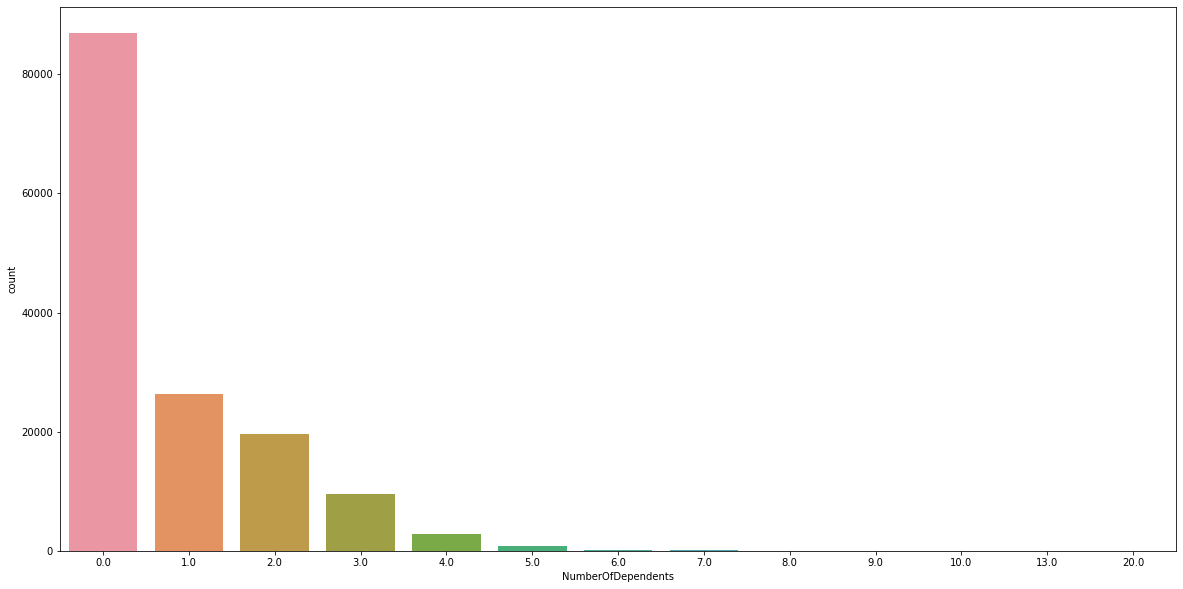

In [8]:
# Distribution of NumberOfDependents
# We can impute the missing values with its mode, which is 0
plt.figure(figsize=(20,10))
sns.countplot(x="NumberOfDependents", data=df_train)

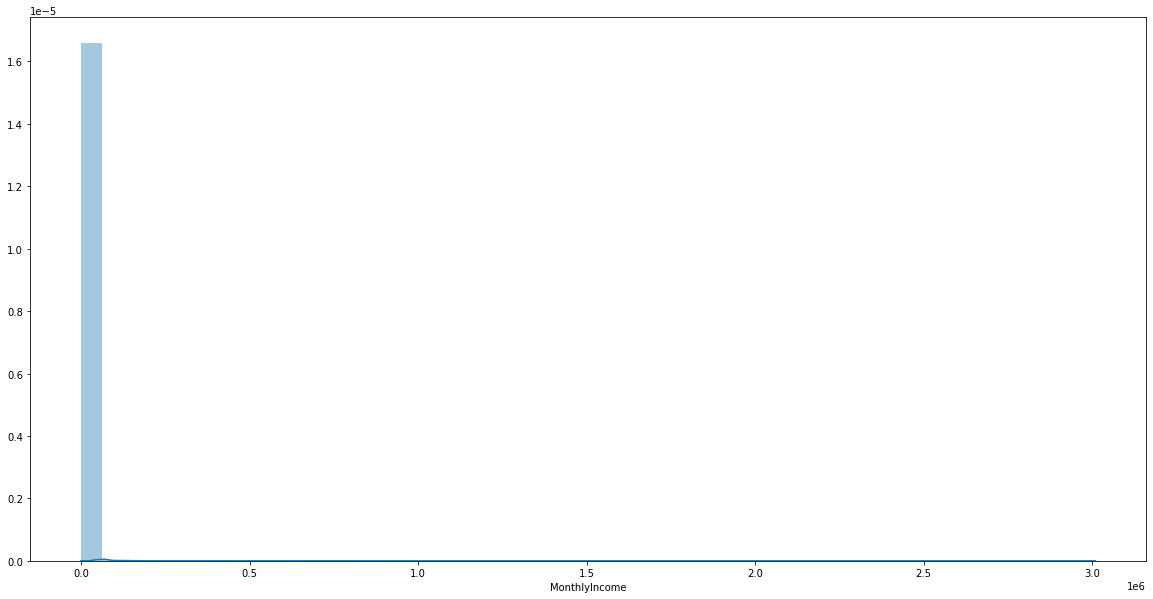

In [9]:
# Distribution of MonthlyIncome
# Highly skewed 
# We can impute the missing values with its mode
plt.figure(figsize=(20,10))
sns.distplot(df_train["MonthlyIncome"])

In [10]:
# Filling in the missing values with the mean
df_train.NumberOfDependents.fillna(0,inplace=True)
df_train.MonthlyIncome.fillna(df_train.MonthlyIncome.median(),inplace=True)

df_test.NumberOfDependents.fillna(0,inplace=True)
df_test.MonthlyIncome.fillna(df_test.MonthlyIncome.median(),inplace=True)

# Exploratory Data Analysis

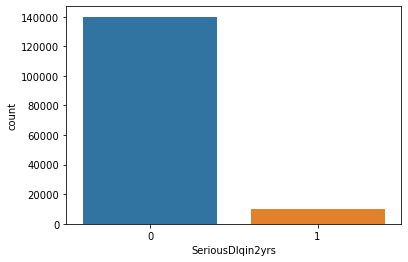

In [11]:
# We want to predict if a person will experience financial distress for next two years
# There is a high imbalance in training set (around 140000 for no, 20000 for yes)
# This is approximately 90% for no and 10% for yes
# The minority class is the class of interest (yes) 
sns.countplot('SeriousDlqin2yrs', data=df_train)

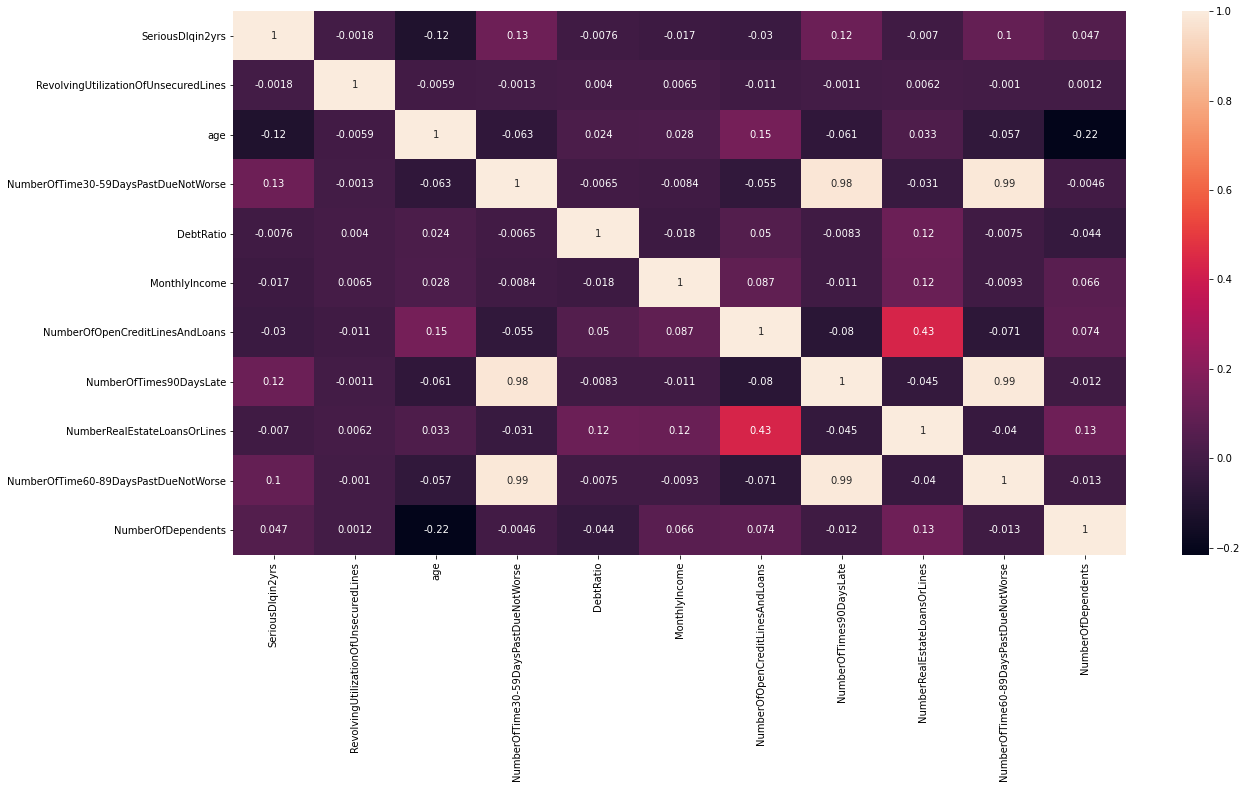

In [12]:
# Let us examine the correlation between the variables

# The following features have negative correlations with our target variable: 
# age, RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines
# The lower these values go, the higher the chance of experiencing financial distress for next two years

# The following features have positive correlations with our target variable:
# NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents
# The higher these values go, the higher the chance of experiencing financial distress for next two years


corr = df_train.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True)
plt.show()
corr = np.array(corr)

# Classification Model

In [13]:
x = df_train.drop(columns=['SeriousDlqin2yrs'])
y = df_train['SeriousDlqin2yrs']

In [14]:
def plot_roc(pred):
    fpr,tpr,_ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    sns.lineplot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [15]:
# Perform 5 fold Cross Validation 
kf = KFold(n_splits=5, random_state=None) 
for train_index, test_index in kf.split(x):
    print("Train:", train_index, "Validation:", test_index)
    x_train, x_test = x.values[train_index], x.values[test_index] 
    y_train, y_test = y.values[train_index], y.values[test_index]

Train: [ 30000  30001  30002 ... 149997 149998 149999] Validation: [    0     1     2 ... 29997 29998 29999]
Train: [     0      1      2 ... 149997 149998 149999] Validation: [30000 30001 30002 ... 59997 59998 59999]
Train: [     0      1      2 ... 149997 149998 149999] Validation: [60000 60001 60002 ... 89997 89998 89999]
Train: [     0      1      2 ... 149997 149998 149999] Validation: [ 90000  90001  90002 ... 119997 119998 119999]
Train: [     0      1      2 ... 119997 119998 119999] Validation: [120000 120001 120002 ... 149997 149998 149999]


In [16]:
# Create a metrics dataframe to store evaluation results
Metrics = pd.DataFrame({'Accuracy':[], 'MCC':[], 'Precision':[], 'Recall':[], 'F1':[], 'AUC':[]})

In [17]:
# Perform SMOTE to handle imbalance in training data
smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 2, random_state=0)
x_train_smote, y_train_smote = smote.fit_sample(x_train, y_train)

# K-Nearest Neighbour

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_smote, y_train_smote)
y_predict = knn.predict(x_test)

print(metrics.classification_report(y_test,y_predict))
print('MCC:', metrics.matthews_corrcoef(y_test,y_predict))

pred = knn.predict_proba(x_test)[:,1]
print('AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     27956
           1       0.11      0.32      0.16      2044

    accuracy                           0.78     30000
   macro avg       0.53      0.57      0.52     30000
weighted avg       0.89      0.78      0.82     30000

MCC: 0.08277245144249933
AUC: 0.5876611667369943


In [19]:
new_row = pd.Series(data={'Accuracy':0.78, 'MCC':0.08, 'Precision':0.11, 'Recall':0.32, 'F1':0.16, 'AUC':0.59}, name='KNN')
Metrics = Metrics.append(new_row, ignore_index=False)

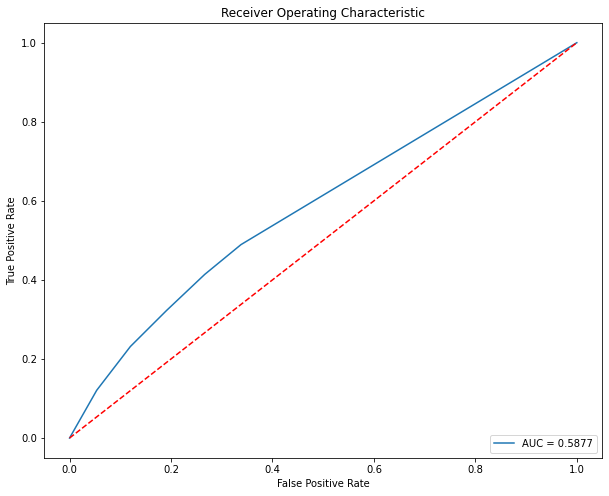

In [20]:
plot_roc(pred)

# Decision Tree

In [21]:
dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dtc.fit(x_train_smote,y_train_smote)
y_predict = dtc.predict(x_test)
probab = dtc.predict_proba(x_test)

print(metrics.classification_report(y_test,y_predict))
print('MCC:', metrics.matthews_corrcoef(y_test,y_predict))

pred = dtc.predict_proba(x_test)[:,1]
print('AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     27956
           1       0.37      0.43      0.40      2044

    accuracy                           0.91     30000
   macro avg       0.66      0.69      0.67     30000
weighted avg       0.92      0.91      0.91     30000

MCC: 0.3511173055714305
AUC: 0.8350229263682178


In [22]:
new_row = pd.Series(data={'Accuracy':0.91, 'MCC':0.35, 'Precision':0.37, 'Recall':0.43, 'F1':0.40, 'AUC':0.84}, name='DT')
Metrics = Metrics.append(new_row, ignore_index=False)

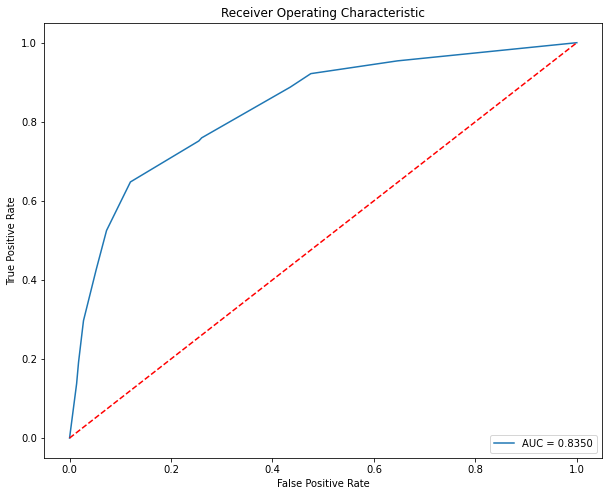

In [23]:
plot_roc(pred)

# Naive Bayes Classifier (GaussianNB)

In [24]:
gnb = GaussianNB()
gnb.fit(x_train_smote,y_train_smote)
y_predict = gnb.predict(x_test)
probab = gnb.predict_proba(x_test)

print(metrics.classification_report(y_test,y_predict))
print('MCC:', metrics.matthews_corrcoef(y_test,y_predict))

pred = gnb.predict_proba(x_test)[:,1]
print('AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.96     27956
           1       0.50      0.06      0.11      2044

    accuracy                           0.93     30000
   macro avg       0.72      0.53      0.54     30000
weighted avg       0.91      0.93      0.91     30000

MCC: 0.16087469806183416
AUC: 0.7134939595461585


In [25]:
new_row = pd.Series(data={'Accuracy':0.93, 'MCC':0.16, 'Precision':0.50, 'Recall':0.06, 'F1':0.11, 'AUC':0.71}, name='NB')
Metrics = Metrics.append(new_row, ignore_index=False)

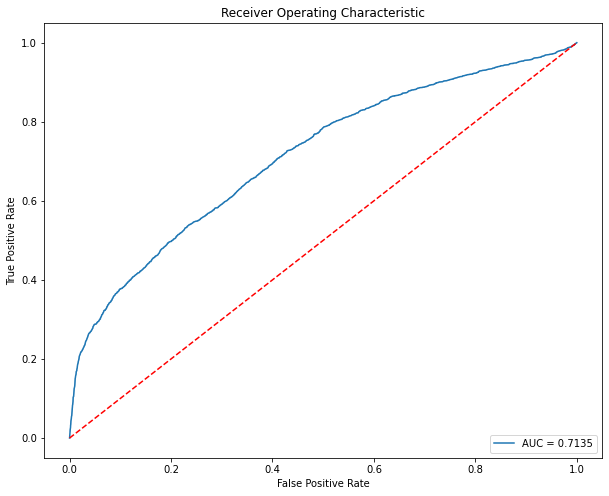

In [26]:
plot_roc(pred)

# Random Forest

In [27]:
rfc = RandomForestClassifier(n_estimators=300,criterion='entropy',max_depth=5,random_state=10)
rfc.fit(x_train_smote,y_train_smote)
y_predict = rfc.predict(x_test)
probab = rfc.predict_proba(x_test)

print(metrics.classification_report(y_test,y_predict))
print('MCC:', metrics.matthews_corrcoef(y_test,y_predict))

pred = rfc.predict_proba(x_test)[:,1]
print('AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     27956
           1       0.30      0.61      0.41      2044

    accuracy                           0.88     30000
   macro avg       0.64      0.76      0.67     30000
weighted avg       0.92      0.88      0.90     30000

MCC: 0.37323612301013337
AUC: 0.8568983524991327


In [28]:
new_row = pd.Series(data={'Accuracy':0.88, 'MCC':0.37, 'Precision':0.30, 'Recall':0.61, 'F1':0.41, 'AUC':0.86}, name='RF')
Metrics = Metrics.append(new_row, ignore_index=False)

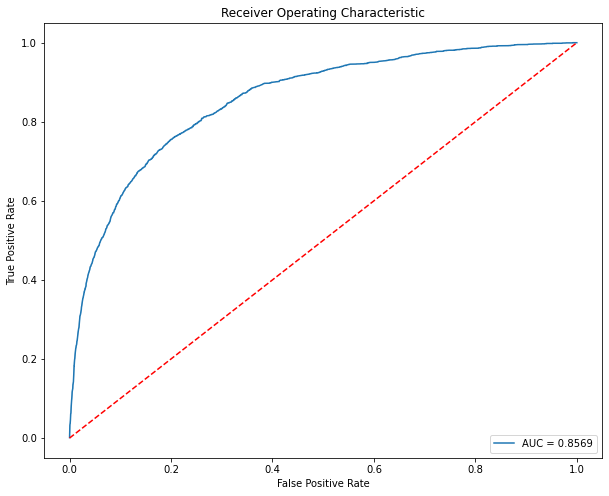

In [29]:
plot_roc(pred)

# Light GBM

In [30]:
Lgb = LGBMClassifier(objective='binary',metrics ='auc')
Lgb.fit(x_train_smote,y_train_smote)
y_predict = Lgb.predict(x_test)
probab = Lgb.predict_proba(x_test)

print(metrics.classification_report(y_test,y_predict))
print('MCC:', metrics.matthews_corrcoef(y_test,y_predict))

pred = Lgb.predict_proba(x_test)[:,1]
print('AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27956
           1       0.55      0.23      0.33      2044

    accuracy                           0.93     30000
   macro avg       0.75      0.61      0.65     30000
weighted avg       0.92      0.93      0.92     30000

MCC: 0.33119694318079573
AUC: 0.8663790390910626


In [31]:
new_row = pd.Series(data={'Accuracy':0.93, 'MCC':0.33, 'Precision':0.55, 'Recall':0.23, 'F1':0.33, 'AUC':0.87}, name='LightGBM')
Metrics = Metrics.append(new_row, ignore_index=False)

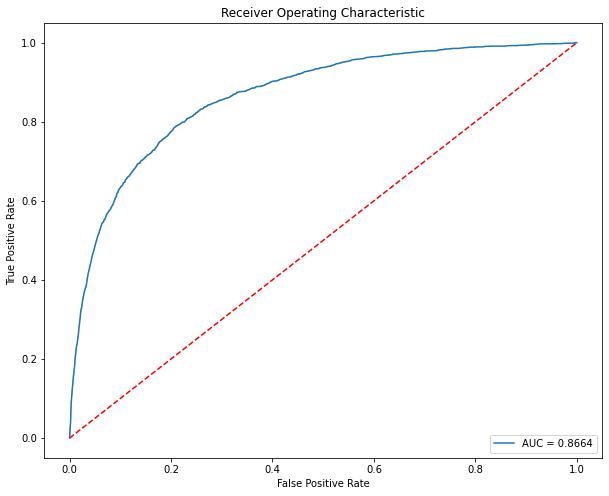

In [32]:
plot_roc(pred)

In [33]:
Metrics.sort_values(by=['AUC'],ascending=False)

,Accuracy,MCC,Precision,Recall,F1,AUC
LightGBM,0.93,0.33,0.55,0.23,0.33,0.87
RF,0.88,0.37,0.30,0.61,0.41,0.86
DT,0.91,0.35,0.37,0.43,0.40,0.84
NB,0.93,0.16,0.50,0.06,0.11,0.71
KNN,0.78,0.08,0.11,0.32,0.16,0.59


In [34]:
#prediction
pred = rfc.predict_proba(df_test)[:,1]

#output
output = pd.DataFrame({'Id': df_test.index, 'Probability': pred})
output.to_csv('submission.csv', index=False)